In [5]:
import nltk

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from pyemd import emd
from multiprocessing import Pool

%matplotlib inline

In [6]:
with open('compilersSelfPacedCS1ClosedCaptions.txt') as f:
    raw = ' '.join([line.strip().replace('&#39;', "'") for line in f])

tokens = nltk.word_tokenize(raw)

lemmatizer = nltk.WordNetLemmatizer()

for i, token in enumerate(tokens):
    try:
        tokens[i] = lemmatizer.lemmatize(token)
    except UnicodeDecodeError:
        tokens.pop(i)
    
normalize_line = lambda line: line.strip().lower().replace('-', ' ')

with open('dragonIndex') as f:
    dragon_index = [normalize_line(line) for line in f]
    
for i, entry in enumerate(dragon_index):
    entry_tokens = nltk.word_tokenize(entry)
    dragon_index[i] = ' '.join([lemmatizer.lemmatize(token) for token in entry_tokens])

In [7]:
# http://www.ranks.nl/stopwords
with open('ranks_nl_stop_words_long.txt') as f:
    stop_words = [line.strip().replace("'", '') for line in f]
# A few added stop words
stop_words.extend([
        'thing',
        'things',
        'hello', 
        'going', 
        'uh', 
        'gonna', 
        'jack', 
        'will', 
        'alright',
        'cuz',
        'a0',
        'a1',
        'e0',
        'e1',
        'e2',
        'forgot',
        'graduate',
        'hope',
        'r1',
        's1',
        's2',
        'x1',
        'a2i',
        'en',
        'bs',
        'idea',
        'keep',
        'sa',
        'gon',
        'eventually',
        'excuse'
    ])
# A few removed stop words
stop_words.remove('first')

In [10]:
window_size = 100
n_windows = int(np.ceil(float(len(tokens)) / window_size))
documents = [' '.join(tokens[i * window_size:(i + 1) * window_size]) for i in range(n_windows)]
cv = CountVectorizer(ngram_range=(1, 3), stop_words=stop_words, max_features=2000)
cv.fit(documents)

vocabulary = set(cv.vocabulary_.keys())

# Filter out tokens like 'abstract abstract'
no_repeats = lambda string: Counter(string.split()).most_common()[0][1] == 1

# Don't keep tokens like 'abstract' or 'abstract syntax tree' if there is another token 'abstract syntax tree'
unique_substring = lambda string: not any([string in other for other in vocabulary - set([string])])

filtered_vocabulary = filter(lambda string: no_repeats(string) and unique_substring(string), vocabulary)

cv_filtered = CountVectorizer(
    ngram_range=cv.ngram_range, 
    stop_words=stop_words, 
    vocabulary=filtered_vocabulary
)
frequency_matrix = cv_filtered.fit_transform(documents)
frequency_matrix = frequency_matrix.tocsc()

In [12]:
distance_matrix = np.zeros((n_windows, n_windows))
for i in range(n_windows):
    for j in range(n_windows):
        distance_matrix[i][j] = abs(i - j)

def earth_movers_distance(arr):
    arr = arr.flatten().astype('float64')
    uniform = np.empty(arr.shape)
    uniform.fill(arr.mean())
    return emd(arr, uniform, distance_matrix)

In [13]:
def map_fn(i):     
    return earth_movers_distance(frequency_matrix[:,i].toarray())

p = Pool(processes=10)
distances = p.map(map_fn, range(frequency_matrix.shape[1]))

sorted_indices = sorted(range(len(distances)), key=lambda i: distances[i])
inverse_vocab = {v: k for k, v in cv_filtered.vocabulary_.items()}

In [14]:
inverse_vocab = {v: k for k, v in cv_filtered.vocabulary_.items()}
print [inverse_vocab[i] for i in sorted_indices[:50]]
print [inverse_vocab[i] for i in sorted_indices[-50:]]

[u'example first', u'language compiler', u'linear', u'presumably', u'video talking', u'video discussion', u'break', u'usage', u'elaborate', u'concept', u'finding', u'includes', u'contrast', u'weak', u'example video', u'returning', u'draw picture', u'program first', u'finished', u'program doe', u'moving', u'method argument', u'keeping', u'number three', u'instance', u'variety', u'focusing', u'observe', u'time wa', u'higher level', u'encounter', u'automatically', u'long time', u'sufficient', u'field object', u'first time', u'ago', u'point time', u'middle', u'intuitively', u'treat', u'family language', u'thinking', u'limitation', u'effort', u'multiplication', u'simple example', u'absolutely', u'write code', u'example expression']
[u'alternative', u'notation', u'pointer object', u'interpreter', u'left hand side', u'interesting', u'layout', u'top stack', u'regular language', u'input pointer', u'working', u'hand side production', u'neighbor', u'operator', u'dead', u'course', u'meaning', u'in

0.0499125733536
1191.73550997


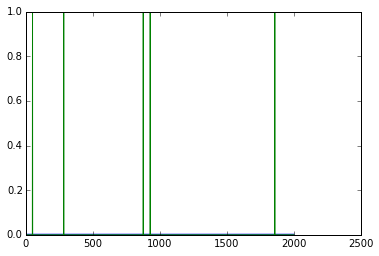

In [16]:
frequencies = frequency_matrix[:, cv_filtered.vocabulary_['family language']].toarray()
uniform = np.empty(frequencies.shape)
uniform.fill(frequencies.mean())
print frequencies.std()
print earth_movers_distance(frequencies)
plt.plot(uniform)
_ = plt.plot(frequencies)

0.150627355122
26647.5229457


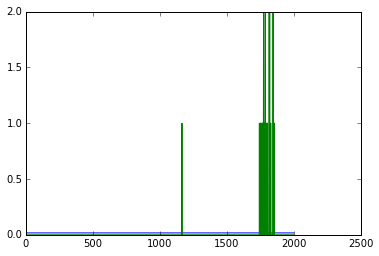

In [18]:
frequencies = frequency_matrix[:, cv_filtered.vocabulary_['garbage collection']].toarray()
uniform = np.empty(frequencies.shape)
uniform.fill(frequencies.mean())
print frequencies.reshape(1, -1).astype('float64').std()
print earth_movers_distance(frequencies)
plt.plot(uniform)
_ = plt.plot(frequencies)

In [20]:
jaccard_score = lambda s1, s2: float(len(s1.intersection(s2))) / len(s1.union(s2))

jaccard_scores = [jaccard_score(
    set([inverse_vocab[i] for i in sorted_indices[-index_size:]]), 
    dragon_index
) for index_size in range(len(sorted_indices))]

best_size, best_score = max([tup for tup in enumerate(jaccard_scores)], key=lambda (i, score): score)
best_index = [(inverse_vocab[i], distances[i]) for i in sorted_indices[-index_size:]]
print best_size, best_score
print best_index

382 0.0467128027682
[(u'language compiler', 691.6210827225837), (u'linear', 723.721079700084), (u'presumably', 755.4648787715915), (u'video talking', 816.8104944626978), (u'video discussion', 869.785750537585), (u'break', 871.5420337927327), (u'usage', 877.5860337300852), (u'elaborate', 891.6709226550853), (u'concept', 894.5333961969668), (u'finding', 902.7756022200853), (u'includes', 932.2190087661747), (u'contrast', 961.8494851484143), (u'weak', 973.9627922191363), (u'example video', 976.5017694013002), (u'returning', 980.896963380547), (u'draw picture', 1003.7616968134304), (u'program first', 1011.1625659587104), (u'finished', 1013.9304168525863), (u'program doe', 1014.5734167358321), (u'moving', 1016.1264104966384), (u'method argument', 1022.7412320665444), (u'keeping', 1027.5205785375863), (u'number three', 1067.5009887525866), (u'instance', 1080.9060879485387), (u'variety', 1083.7805294550867), (u'focusing', 1092.3481985327328), (u'observe', 1096.953090444551), (u'time wa', 1102.

In [32]:
with open('emd_index.txt', 'w') as f:
    f.write('{} phrases, jaccard score: {}\n\n'.format(best_size, best_score))
    left_col_size = max([len(phrase) for phrase, distance in best_index])
    fmt_string = '{{:<{}}}: {{}}\n'.format(left_col_size)
    for phrase, distance in best_index:
        f.write(fmt_string.format(phrase, distance))